In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix, roc_auc_score
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import BorderlineSMOTE
import warnings

In [2]:
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv(".\\DATA\\Telco-Customer-Churn.csv")

## 1. Training model on imbalanced dataset

### Train Test Split

In [4]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [5]:
X = df.drop(["Churn", "customerID"], axis=1)
X = pd.get_dummies(X)

In [6]:
y = df["Churn"]

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

### GridSearch Cross Validation

In [8]:
n_estimators = [10,20,50,100]
max_features = ["sqrt", "log2", None]
learning_rate_ada = [0.05,0.5,1.,1.5, 3]
learning_rate_gradient = [0.01, 0.05, 0.1, 0.3, 0.5, 0.8, 1]
max_depth = [2,3,4,5,6,7]

In [9]:
param_grid_random = {"n_estimators": n_estimators, "max_features": max_features}

param_grid_ada = {"n_estimators":n_estimators, "learning_rate":learning_rate_ada}

param_grid_gradient = {"learning_rate":learning_rate_gradient, "n_estimators":n_estimators,"max_depth":max_depth, "max_features":max_features}

In [10]:
rfc = RandomForestClassifier()

In [11]:
abc = AdaBoostClassifier()

In [12]:
gbc = GradientBoostingClassifier()

In [13]:
def fitter(estimator, param_grid, X_train, y_train):
    grid_model = GridSearchCV(estimator, param_grid)
    grid_model.fit(X_train, y_train)
    grid_model = grid_model.best_estimator_
    return grid_model

In [14]:
grid_rfc = fitter(rfc, param_grid_random, X_train, y_train)

In [15]:
grid_rfc

RandomForestClassifier(n_estimators=50)

In [16]:
grid_abc = fitter(abc, param_grid_ada, X_train, y_train)

In [17]:
grid_abc

AdaBoostClassifier(learning_rate=0.5, n_estimators=100)

In [18]:
grid_gbc = fitter(gbc, param_grid_gradient, X_train, y_train)

In [19]:
grid_gbc

GradientBoostingClassifier(learning_rate=0.05)

In [20]:
def evaluate(estimator, X_test): 
    print(f"{estimator}")
    predictions = estimator.predict(X_test)
    cm = confusion_matrix(y_test, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap="seismic")
    print(classification_report(y_test, predictions))
    
    def change(value):
        if value == "Yes":
            return True
        else: 
            return False
        
    v_change = np.vectorize(change)
    print(f"roc_auc_score = {round(roc_auc_score(v_change(y_test), v_change(predictions)), 2)}")

RandomForestClassifier(n_estimators=50)
              precision    recall  f1-score   support

          No       0.82      0.90      0.86       517
         Yes       0.63      0.46      0.53       187

    accuracy                           0.79       704
   macro avg       0.73      0.68      0.70       704
weighted avg       0.77      0.79      0.77       704

roc_auc_score = 0.68


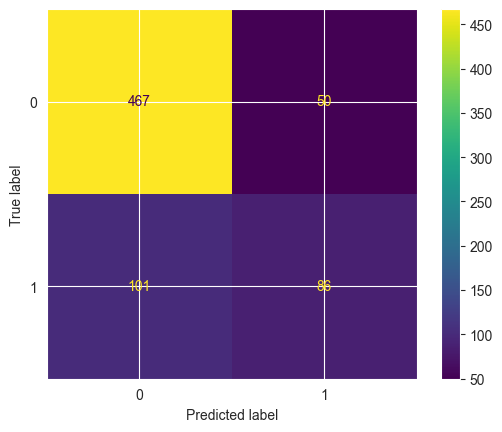

In [21]:
evaluate(grid_rfc, X_test)

AdaBoostClassifier(learning_rate=0.5, n_estimators=100)
              precision    recall  f1-score   support

          No       0.83      0.88      0.85       517
         Yes       0.59      0.49      0.53       187

    accuracy                           0.77       704
   macro avg       0.71      0.68      0.69       704
weighted avg       0.76      0.77      0.77       704

roc_auc_score = 0.68


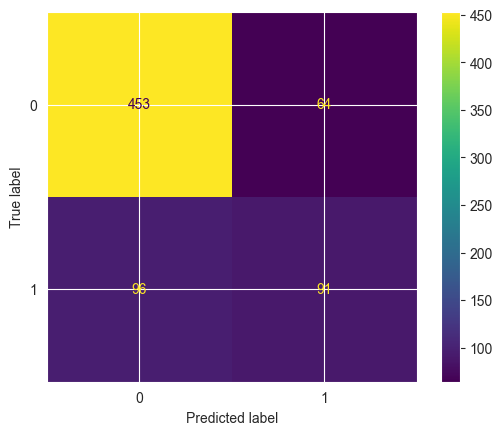

In [22]:
evaluate(grid_abc, X_test)

GradientBoostingClassifier(learning_rate=0.05)
              precision    recall  f1-score   support

          No       0.83      0.90      0.86       517
         Yes       0.63      0.49      0.55       187

    accuracy                           0.79       704
   macro avg       0.73      0.69      0.71       704
weighted avg       0.78      0.79      0.78       704

roc_auc_score = 0.69


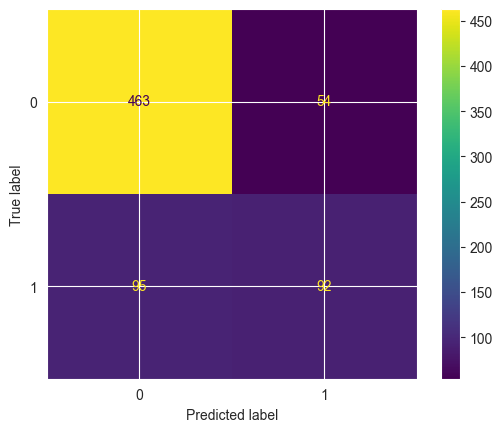

In [23]:
evaluate(grid_gbc, X_test)

### Further GradientBoostClassifier adjustment

In [24]:
grid_gbc

GradientBoostingClassifier(learning_rate=0.05)

In [25]:
learning_rate_gradient_second = [0.03, 0.04, 0.05, 0.06, 0.07]
param_grid_gradient_second = {"n_estimators": [100], "learning_rate": learning_rate_gradient_second}

In [26]:
grid_gbc_second = fitter(gbc, param_grid_gradient_second, X_train, y_train)

In [27]:
grid_gbc_second

GradientBoostingClassifier(learning_rate=0.05)

grid_gbc_second is the same as grid_gbc

### Support vector classifier adjustment

In [29]:
svc = SVC()

In [30]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [31]:
param_grid_svc = {"C":[0.0001, 0.001, 0.01, 0.1, 1, 1.1, 10, 100], "gamma": ["scale", "auto"], "kernel": ["linear", "rbf"], "class_weight":[None, "balanced"]}

In [32]:
grid_svc = fitter(svc, param_grid_svc,X_train_scaled, y_train)

In [33]:
grid_svc

SVC(C=1)

SVC(C=1)
              precision    recall  f1-score   support

          No       0.82      0.89      0.85       517
         Yes       0.60      0.47      0.53       187

    accuracy                           0.78       704
   macro avg       0.71      0.68      0.69       704
weighted avg       0.76      0.78      0.77       704

roc_auc_score = 0.68


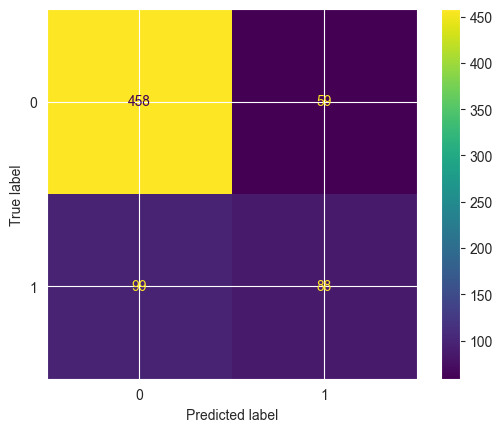

In [34]:
evaluate(grid_svc, X_test_scaled)

GradientBoostingClassifier performed better

## 2. BorderlineSMOTE

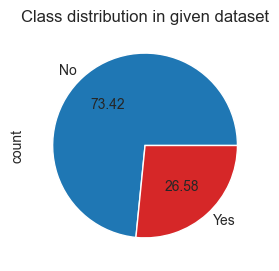

In [35]:
plt.figure(figsize=(3,3))
colors = [sns.color_palette("tab10")[0], sns.color_palette("tab10")[3]]
df["Churn"].value_counts().plot.pie(autopct="%.2f", colors=colors)
plt.title("Class distribution in given dataset");

Pretty imbalanced dataset

In [36]:
#over = SMOTE(sampling_strategy=0.1)
#under = RandomUnderSampler(sampling_strategy=0.5)

In [37]:
#steps = [('o', over), ('u', under)]
#pipeline = Pipeline(steps=steps)

In [38]:
#X_train_balanced, y_train_balanced = pipeline.fit_resample(X_train, y_train)

In [39]:
oversample = BorderlineSMOTE()
X_train_balanced, y_train_balanced = oversample.fit_resample(X_train, y_train)

In [40]:
grid_gbc_balanced = fitter(gbc, param_grid_gradient, X_train_balanced, y_train_balanced)

GradientBoostingClassifier(max_depth=6, max_features='log2', n_estimators=50)
              precision    recall  f1-score   support

          No       0.85      0.84      0.84       517
         Yes       0.57      0.58      0.58       187

    accuracy                           0.77       704
   macro avg       0.71      0.71      0.71       704
weighted avg       0.77      0.77      0.77       704

roc_auc_score = 0.71


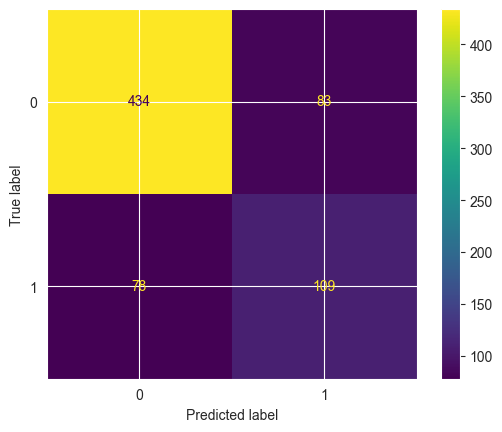

In [41]:
evaluate(grid_gbc_balanced, X_test)